<a href="https://colab.research.google.com/github/hwansnaa/InfoGAN/blob/main/infoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

MNIST

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.tconv1 = nn.ConvTranspose2d(74, 1024, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(1024)

        self.tconv2 = nn.ConvTranspose2d(1024, 128, 7, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.tconv3 = nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.tconv4 = nn.ConvTranspose2d(64, 1, 4, 2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))

        img = torch.sigmoid(self.tconv4(x))

        return img

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)

        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 1024, 7, bias=False)
        self.bn3 = nn.BatchNorm2d(1024)

        self.conv4 = nn.Conv2d(1024, 1, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.1, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1, inplace=True)
        output = F.leaky_relu(self.bn3(self.conv3(x)), 0.1, inplace=True)
        probs = torch.sigmoid(self.conv4(output))

        return probs, output

class QHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1024, 128, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)

        self.conv_disc = nn.Conv2d(128, 10, 1)
        self.conv_mu = nn.Conv2d(128, 2, 1)
        self.conv_var = nn.Conv2d(128, 2, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)

        disc_logits = self.conv_disc(x).squeeze()

        mu = self.conv_mu(x).squeeze()
        var = torch.exp(self.conv_var(x).squeeze())

        return disc_logits, mu, var

In [ ]:
params = {
    'batch_size': 128,# Batch size.
    'num_epochs': 100,# Number of epochs to train for.
    'learning_rate': 2e-4,# Learning rate.
    'beta1': 0.5,
    'beta2': 0.999,
    'save_epoch' : 25,# After how many epochs to save checkpoints and generate test output.
    'dataset' : 'MNIST'
}
params['num_z'] = 62
params['num_dis_c'] = 1
params['dis_c_dim'] = 10
params['num_con_c'] = 2

In [ ]:
def noise_sample(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):
    """
    Sample random noise vector for training.
    INPUT
    --------
    n_dis_c : Number of discrete latent code.
    dis_c_dim : Dimension of discrete latent code.
    n_con_c : Number of continuous latent code.
    n_z : Dimension of iicompressible noise.
    batch_size : Batch Size
    device : GPU/CPU
    """

    z = torch.randn(batch_size, n_z, 1, 1, device=device)

    idx = np.zeros((n_dis_c, batch_size))
    if(n_dis_c != 0):
        dis_c = torch.zeros(batch_size, n_dis_c, dis_c_dim, device=device)
        
        for i in range(n_dis_c):
            idx[i] = np.random.randint(dis_c_dim, size=batch_size)
            dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0

        dis_c = dis_c.view(batch_size, -1, 1, 1)

    if(n_con_c != 0):
        # Random uniform between -1 and 1.
        con_c = torch.rand(batch_size, n_con_c, 1, 1, device=device) * 2 - 1

    noise = z
    if(n_dis_c != 0):
        noise = torch.cat((z, dis_c), dim=1)
    if(n_con_c != 0):
        noise = torch.cat((noise, con_c), dim=1)

    return noise, idx

In [ ]:
class InfoGAN:
  def __init__(self, params):
      self.params = params
      self.netG = Generator()
      self.netD = Discriminator()
      self.netQ = QHead()
      self.optimD = optim.Adam([{'params': self.netD.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))
      self.optimG = optim.Adam([{'params': self.netG.parameters()}, {'params': self.netQ.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))

      self.criterionD = nn.BCELoss()
      self.criterionQ_dis = nn.CrossEntropyLoss()
      self.criterionQ_con = nn.GaussianNLLLoss()
      
      self.device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

  def train(self, ds, epochs = 100):
    self.netG = self.netG.to(self.device)
    self.netD = self.netD.to(self.device)
    self.netQ = self.netQ.to(self.device)
    self.G_losses = []
    self.D_losses = []
    self.val_outputs = []
    self.val_noise, idx = noise_sample(self.params['num_dis_c'], self.params['dis_c_dim'], self.params['num_con_c'], self.params['num_z'], 36, self.device)
    for epoch in range(epochs):
      for i, (data, _) in enumerate(ds, 0):
          # Get batch size
          b_size = data.size(0)
          # Transfer data tensor to GPU/CPU (device)
          real_data = data.to(self.device)

          # Updating discriminator and DHead
          self.optimD.zero_grad()
          # Real data
          label = torch.full((b_size, ), 1, device=self.device, dtype=torch.float32)
          probs_real, _ = self.netD(real_data)
          loss_real = self.criterionD(probs_real.view(-1), label)
          
          loss_real.backward()

          # Fake data
          label.fill_(0)
          noise, idx = noise_sample(self.params['num_dis_c'], self.params['dis_c_dim'], self.params['num_con_c'], self.params['num_z'], b_size, self.device)
          fake_data = self.netG(noise)
          probs_fake, output_fake = self.netD(fake_data.detach())
          loss_fake = self.criterionD(probs_fake.view(-1), label)
          # Calculate gradients.
          loss_fake.backward()

          # Net Loss for the discriminator
          D_loss = loss_real + loss_fake
          # Update parameters
          self.optimD.step()

          # Updating Generator and QHead
          self.optimG.zero_grad()

          # Fake data treated as real.
          probs_fake, output_fake = self.netD(fake_data)
          label.fill_(1)
          gen_loss = self.criterionD(probs_fake.view(-1), label)

          q_logits, q_mu, q_var = self.netQ(output_fake)
          target = torch.LongTensor(idx).to(self.device)
          # Calculating loss for discrete latent code.
          dis_loss = 0
          for j in range(self.params['num_dis_c']):
              dis_loss += self.criterionQ_dis(q_logits[:, j*10 : j*10 + 10], target[j])

          # Calculating loss for continuous latent code.
          con_loss = 0
          if (self.params['num_con_c'] != 0):
              con_loss = self.criterionQ_con(noise[:, self.params['num_z']+ self.params['num_dis_c']*self.params['dis_c_dim'] : ].view(-1, self.params['num_con_c']), q_mu, q_var)*0.1

          # Net loss for generator.
          G_loss = gen_loss + dis_loss + con_loss
          # Calculate gradients.
          G_loss.backward()
          # Update parameters.
          self.optimG.step()

          # Check progress of training.
          if i != 0 and i%100 == 0:
              print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                    % (epoch+1,self. params['num_epochs'], i, len(ds), 
                      D_loss.item(), G_loss.item()))

          # Save the losses for plotting.
          self.G_losses.append(G_loss.item())
          self.D_losses.append(D_loss.item())
      with torch.no_grad():
        self.netG.eval()
        val_output = self.netG(val_noise)
        grid_image = vutils.make_grid(self.val_output.detach().cpu(), normalize=True).permute(1, 2, 0)
        self.val_outputs.append(grid_image)
        plt.imshow(grid_image)
        plt.axis('off')
        plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor()])
datasets = dsets.MNIST('data/mnist/', train='train', download=True, transform = transform)
dataloader = torch.utils.data.DataLoader(datasets, 
                                            batch_size=64, 
                                            shuffle=True)

[1/100][100/938]	Loss_D: 0.8221	Loss_G: 1.5679
[1/100][200/938]	Loss_D: 0.6891	Loss_G: 1.8109
[1/100][300/938]	Loss_D: 0.6309	Loss_G: 1.6945
[1/100][400/938]	Loss_D: 0.8913	Loss_G: 1.5998
[1/100][500/938]	Loss_D: 0.7167	Loss_G: 1.7642
[1/100][600/938]	Loss_D: 0.6626	Loss_G: 1.6243
[1/100][700/938]	Loss_D: 0.8236	Loss_G: 1.4835
[1/100][800/938]	Loss_D: 0.7973	Loss_G: 1.6453
[1/100][900/938]	Loss_D: 0.8320	Loss_G: 1.6025


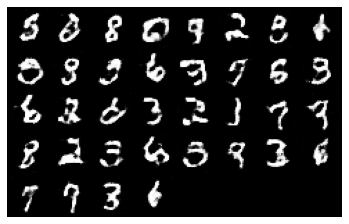

[2/100][100/938]	Loss_D: 0.8407	Loss_G: 1.5411
[2/100][200/938]	Loss_D: 0.9238	Loss_G: 1.4937
[2/100][300/938]	Loss_D: 0.8311	Loss_G: 1.4716
[2/100][400/938]	Loss_D: 0.8494	Loss_G: 1.4339
[2/100][500/938]	Loss_D: 1.0439	Loss_G: 1.3695
[2/100][600/938]	Loss_D: 0.9456	Loss_G: 1.2696
[2/100][700/938]	Loss_D: 1.0101	Loss_G: 1.4635
[2/100][800/938]	Loss_D: 0.9558	Loss_G: 1.2928
[2/100][900/938]	Loss_D: 1.1066	Loss_G: 1.3302


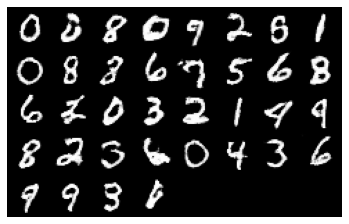

[3/100][100/938]	Loss_D: 0.9607	Loss_G: 1.4657
[3/100][200/938]	Loss_D: 1.0768	Loss_G: 1.4332
[3/100][300/938]	Loss_D: 0.9438	Loss_G: 1.4123
[3/100][400/938]	Loss_D: 0.9344	Loss_G: 1.2859
[3/100][500/938]	Loss_D: 0.8649	Loss_G: 1.4994
[3/100][600/938]	Loss_D: 0.8449	Loss_G: 1.3726
[3/100][700/938]	Loss_D: 1.1012	Loss_G: 1.1134
[3/100][800/938]	Loss_D: 1.0030	Loss_G: 1.1892
[3/100][900/938]	Loss_D: 1.0762	Loss_G: 1.2563


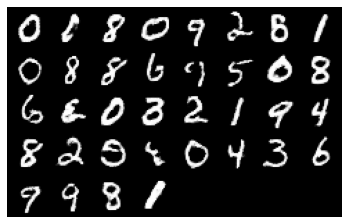

[4/100][100/938]	Loss_D: 0.9446	Loss_G: 1.4878
[4/100][200/938]	Loss_D: 0.9937	Loss_G: 1.2929
[4/100][300/938]	Loss_D: 1.0516	Loss_G: 1.4389
[4/100][400/938]	Loss_D: 0.9285	Loss_G: 1.4552
[4/100][500/938]	Loss_D: 0.9903	Loss_G: 1.2886
[4/100][600/938]	Loss_D: 0.9236	Loss_G: 1.1770
[4/100][700/938]	Loss_D: 1.0297	Loss_G: 1.4219
[4/100][800/938]	Loss_D: 0.9908	Loss_G: 1.4210
[4/100][900/938]	Loss_D: 1.1034	Loss_G: 1.3635


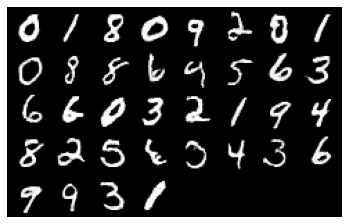

[5/100][100/938]	Loss_D: 0.8532	Loss_G: 1.6635
[5/100][200/938]	Loss_D: 1.1209	Loss_G: 1.2775
[5/100][300/938]	Loss_D: 0.9637	Loss_G: 1.2945
[5/100][400/938]	Loss_D: 1.0965	Loss_G: 1.1482
[5/100][500/938]	Loss_D: 1.0246	Loss_G: 1.2575
[5/100][600/938]	Loss_D: 0.9618	Loss_G: 1.3483
[5/100][700/938]	Loss_D: 1.1451	Loss_G: 1.1718
[5/100][800/938]	Loss_D: 1.0587	Loss_G: 1.3846
[5/100][900/938]	Loss_D: 0.8986	Loss_G: 1.4584


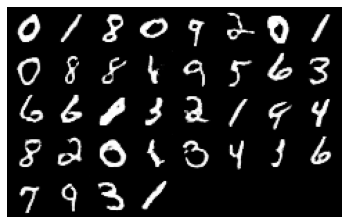

[6/100][100/938]	Loss_D: 1.0440	Loss_G: 1.1555
[6/100][200/938]	Loss_D: 1.1685	Loss_G: 1.0385
[6/100][300/938]	Loss_D: 0.8988	Loss_G: 1.4660
[6/100][400/938]	Loss_D: 1.0948	Loss_G: 1.2562
[6/100][500/938]	Loss_D: 1.0767	Loss_G: 1.3621
[6/100][600/938]	Loss_D: 1.3598	Loss_G: 1.3075
[6/100][700/938]	Loss_D: 0.9622	Loss_G: 1.3419
[6/100][800/938]	Loss_D: 0.8613	Loss_G: 1.3189
[6/100][900/938]	Loss_D: 0.8985	Loss_G: 1.4418


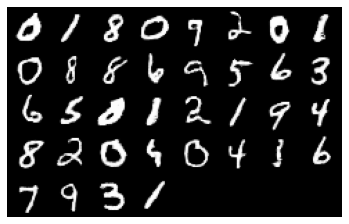

[7/100][100/938]	Loss_D: 0.9149	Loss_G: 1.3025
[7/100][200/938]	Loss_D: 0.8309	Loss_G: 1.4164
[7/100][300/938]	Loss_D: 0.8847	Loss_G: 1.6536
[7/100][400/938]	Loss_D: 0.9828	Loss_G: 1.6196
[7/100][500/938]	Loss_D: 0.8806	Loss_G: 1.1880
[7/100][600/938]	Loss_D: 0.8133	Loss_G: 1.5605
[7/100][700/938]	Loss_D: 0.9076	Loss_G: 1.4658
[7/100][800/938]	Loss_D: 0.8678	Loss_G: 1.3435
[7/100][900/938]	Loss_D: 0.9997	Loss_G: 1.4518


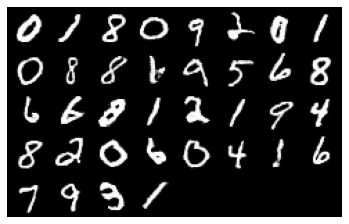

[8/100][100/938]	Loss_D: 0.9816	Loss_G: 1.4565
[8/100][200/938]	Loss_D: 0.7532	Loss_G: 1.6953
[8/100][300/938]	Loss_D: 0.8742	Loss_G: 1.5748
[8/100][400/938]	Loss_D: 0.9953	Loss_G: 1.7684
[8/100][500/938]	Loss_D: 1.1213	Loss_G: 1.3238
[8/100][600/938]	Loss_D: 0.8124	Loss_G: 1.4316
[8/100][700/938]	Loss_D: 0.9886	Loss_G: 1.2017
[8/100][800/938]	Loss_D: 1.1025	Loss_G: 1.7577
[8/100][900/938]	Loss_D: 0.9669	Loss_G: 1.3399


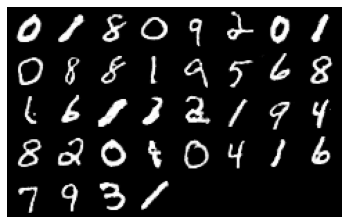

[9/100][100/938]	Loss_D: 1.0068	Loss_G: 1.6882
[9/100][200/938]	Loss_D: 0.9505	Loss_G: 1.4934
[9/100][300/938]	Loss_D: 0.9930	Loss_G: 1.3662
[9/100][400/938]	Loss_D: 0.9056	Loss_G: 1.4755
[9/100][500/938]	Loss_D: 0.7028	Loss_G: 1.6254
[9/100][600/938]	Loss_D: 0.8128	Loss_G: 1.5726
[9/100][700/938]	Loss_D: 0.8952	Loss_G: 1.2508
[9/100][800/938]	Loss_D: 0.7679	Loss_G: 1.8547
[9/100][900/938]	Loss_D: 0.8536	Loss_G: 1.3009


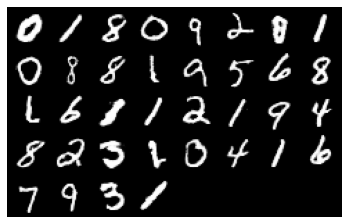

[10/100][100/938]	Loss_D: 0.9501	Loss_G: 1.4402
[10/100][200/938]	Loss_D: 1.0163	Loss_G: 1.4795
[10/100][300/938]	Loss_D: 0.8176	Loss_G: 1.6794
[10/100][400/938]	Loss_D: 0.9475	Loss_G: 1.3978
[10/100][500/938]	Loss_D: 0.7229	Loss_G: 1.5773
[10/100][600/938]	Loss_D: 0.7568	Loss_G: 1.4821
[10/100][700/938]	Loss_D: 0.8871	Loss_G: 1.7611
[10/100][800/938]	Loss_D: 0.8919	Loss_G: 1.5440
[10/100][900/938]	Loss_D: 0.9602	Loss_G: 1.4754


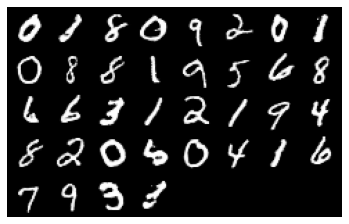

[11/100][100/938]	Loss_D: 0.7009	Loss_G: 1.4235
[11/100][200/938]	Loss_D: 0.7989	Loss_G: 1.7130
[11/100][300/938]	Loss_D: 0.7547	Loss_G: 1.7836
[11/100][400/938]	Loss_D: 0.8993	Loss_G: 1.7703
[11/100][500/938]	Loss_D: 0.8643	Loss_G: 1.4540
[11/100][600/938]	Loss_D: 0.7236	Loss_G: 1.5552
[11/100][700/938]	Loss_D: 0.7997	Loss_G: 1.5110
[11/100][800/938]	Loss_D: 0.7177	Loss_G: 1.7810
[11/100][900/938]	Loss_D: 0.8213	Loss_G: 1.8620


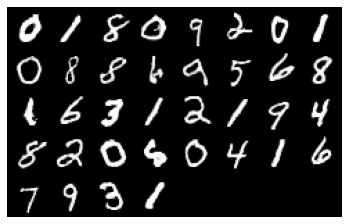

[12/100][100/938]	Loss_D: 0.9174	Loss_G: 1.7126
[12/100][200/938]	Loss_D: 1.0554	Loss_G: 1.6271
[12/100][300/938]	Loss_D: 0.6748	Loss_G: 1.7218
[12/100][400/938]	Loss_D: 0.7988	Loss_G: 1.7957
[12/100][500/938]	Loss_D: 0.7947	Loss_G: 1.4075
[12/100][600/938]	Loss_D: 0.7136	Loss_G: 1.6159
[12/100][700/938]	Loss_D: 0.9459	Loss_G: 1.7651
[12/100][800/938]	Loss_D: 0.7014	Loss_G: 2.1244
[12/100][900/938]	Loss_D: 1.0159	Loss_G: 1.4151


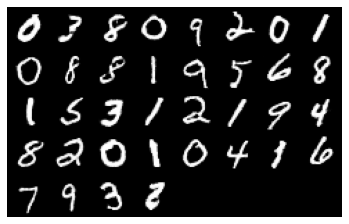

[13/100][100/938]	Loss_D: 0.7657	Loss_G: 1.9415
[13/100][200/938]	Loss_D: 0.7855	Loss_G: 1.6531
[13/100][300/938]	Loss_D: 1.0451	Loss_G: 2.2969
[13/100][400/938]	Loss_D: 0.7919	Loss_G: 1.3092
[13/100][500/938]	Loss_D: 0.7338	Loss_G: 1.3977
[13/100][600/938]	Loss_D: 0.6852	Loss_G: 1.5841
[13/100][700/938]	Loss_D: 0.9493	Loss_G: 1.4584
[13/100][800/938]	Loss_D: 0.8456	Loss_G: 1.8622
[13/100][900/938]	Loss_D: 0.8124	Loss_G: 1.8872


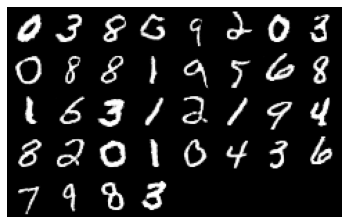

[14/100][100/938]	Loss_D: 0.6104	Loss_G: 2.5307
[14/100][200/938]	Loss_D: 0.7929	Loss_G: 2.1715
[14/100][300/938]	Loss_D: 0.6920	Loss_G: 1.3250
[14/100][400/938]	Loss_D: 0.8253	Loss_G: 1.8086
[14/100][500/938]	Loss_D: 0.7836	Loss_G: 1.8617
[14/100][600/938]	Loss_D: 0.6070	Loss_G: 1.8666
[14/100][700/938]	Loss_D: 0.8794	Loss_G: 1.4979
[14/100][800/938]	Loss_D: 0.8552	Loss_G: 1.7648
[14/100][900/938]	Loss_D: 0.7757	Loss_G: 2.1493


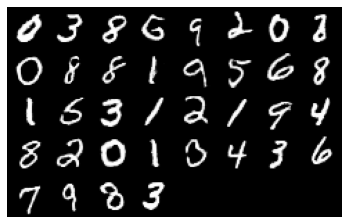

[15/100][100/938]	Loss_D: 0.8052	Loss_G: 1.4506
[15/100][200/938]	Loss_D: 0.9933	Loss_G: 2.2892
[15/100][300/938]	Loss_D: 0.5636	Loss_G: 1.8755
[15/100][400/938]	Loss_D: 0.6705	Loss_G: 1.6762
[15/100][500/938]	Loss_D: 0.7603	Loss_G: 1.8888
[15/100][600/938]	Loss_D: 0.7729	Loss_G: 1.8883
[15/100][700/938]	Loss_D: 0.7524	Loss_G: 1.8794
[15/100][800/938]	Loss_D: 0.8643	Loss_G: 1.7849
[15/100][900/938]	Loss_D: 0.8399	Loss_G: 1.7865


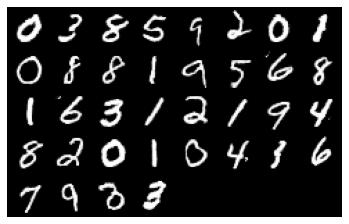

[16/100][100/938]	Loss_D: 0.6852	Loss_G: 2.5518
[16/100][200/938]	Loss_D: 0.6531	Loss_G: 1.7137
[16/100][300/938]	Loss_D: 0.7191	Loss_G: 1.6452
[16/100][400/938]	Loss_D: 0.7623	Loss_G: 2.4920
[16/100][500/938]	Loss_D: 0.7843	Loss_G: 1.7320
[16/100][600/938]	Loss_D: 0.8571	Loss_G: 1.7269
[16/100][700/938]	Loss_D: 0.6509	Loss_G: 1.7932
[16/100][800/938]	Loss_D: 0.5351	Loss_G: 1.8774
[16/100][900/938]	Loss_D: 0.6049	Loss_G: 1.9617


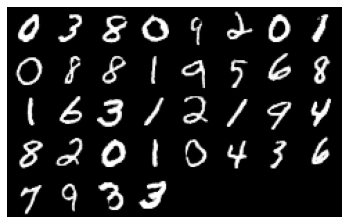

[17/100][100/938]	Loss_D: 0.7591	Loss_G: 2.7071
[17/100][200/938]	Loss_D: 0.6152	Loss_G: 2.1676
[17/100][300/938]	Loss_D: 0.6449	Loss_G: 1.8826
[17/100][400/938]	Loss_D: 0.6312	Loss_G: 2.1434
[17/100][500/938]	Loss_D: 0.8113	Loss_G: 1.9889
[17/100][600/938]	Loss_D: 0.5456	Loss_G: 1.8328
[17/100][700/938]	Loss_D: 0.6528	Loss_G: 1.6067
[17/100][800/938]	Loss_D: 0.7692	Loss_G: 1.5274
[17/100][900/938]	Loss_D: 0.8542	Loss_G: 3.1688


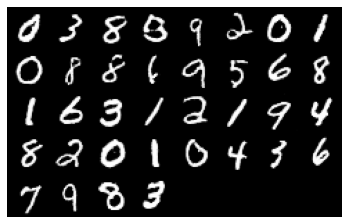

[18/100][100/938]	Loss_D: 0.5576	Loss_G: 2.2543
[18/100][200/938]	Loss_D: 0.7141	Loss_G: 1.7107
[18/100][300/938]	Loss_D: 0.8289	Loss_G: 1.4290
[18/100][400/938]	Loss_D: 0.7133	Loss_G: 1.9737
[18/100][500/938]	Loss_D: 0.7062	Loss_G: 1.2585
[18/100][600/938]	Loss_D: 0.8703	Loss_G: 2.0870
[18/100][700/938]	Loss_D: 0.5446	Loss_G: 2.4739
[18/100][800/938]	Loss_D: 0.7516	Loss_G: 2.5349
[18/100][900/938]	Loss_D: 0.7225	Loss_G: 2.2290


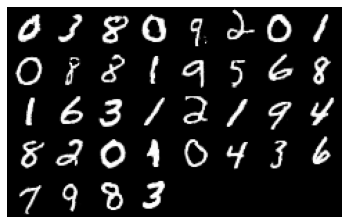

[19/100][100/938]	Loss_D: 0.6550	Loss_G: 1.5071
[19/100][200/938]	Loss_D: 0.6089	Loss_G: 1.7750
[19/100][300/938]	Loss_D: 0.7768	Loss_G: 2.2438
[19/100][400/938]	Loss_D: 0.6095	Loss_G: 2.1540
[19/100][500/938]	Loss_D: 0.6700	Loss_G: 2.0437
[19/100][600/938]	Loss_D: 0.7044	Loss_G: 1.6980
[19/100][700/938]	Loss_D: 0.7814	Loss_G: 1.6248
[19/100][800/938]	Loss_D: 0.5533	Loss_G: 2.0174
[19/100][900/938]	Loss_D: 0.6863	Loss_G: 1.1011


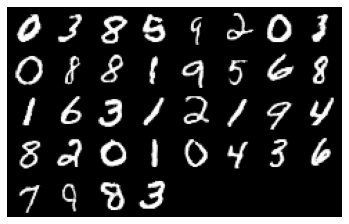

[20/100][100/938]	Loss_D: 0.6777	Loss_G: 2.0906
[20/100][200/938]	Loss_D: 0.6852	Loss_G: 1.6490
[20/100][300/938]	Loss_D: 0.8408	Loss_G: 2.4012
[20/100][400/938]	Loss_D: 0.5693	Loss_G: 1.7997
[20/100][500/938]	Loss_D: 0.6585	Loss_G: 1.9774
[20/100][600/938]	Loss_D: 0.6979	Loss_G: 2.0190
[20/100][700/938]	Loss_D: 0.6284	Loss_G: 1.7560
[20/100][800/938]	Loss_D: 0.7264	Loss_G: 1.8132
[20/100][900/938]	Loss_D: 0.8003	Loss_G: 1.7164


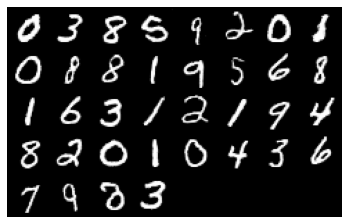

[21/100][100/938]	Loss_D: 0.6597	Loss_G: 2.2145
[21/100][200/938]	Loss_D: 0.4437	Loss_G: 2.1850
[21/100][300/938]	Loss_D: 0.7039	Loss_G: 1.5141
[21/100][400/938]	Loss_D: 0.6261	Loss_G: 1.7165
[21/100][500/938]	Loss_D: 0.6580	Loss_G: 1.7011
[21/100][600/938]	Loss_D: 0.5604	Loss_G: 2.0904
[21/100][700/938]	Loss_D: 0.6072	Loss_G: 2.2100
[21/100][800/938]	Loss_D: 0.8128	Loss_G: 1.3044
[21/100][900/938]	Loss_D: 0.6459	Loss_G: 1.8324


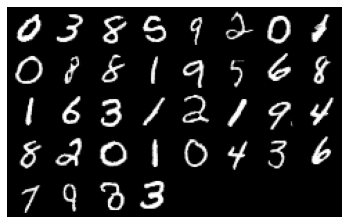

[22/100][100/938]	Loss_D: 0.5835	Loss_G: 3.0005
[22/100][200/938]	Loss_D: 0.4558	Loss_G: 2.8774
[22/100][300/938]	Loss_D: 0.5486	Loss_G: 2.2835
[22/100][400/938]	Loss_D: 0.6278	Loss_G: 1.4740
[22/100][500/938]	Loss_D: 0.5369	Loss_G: 2.4902
[22/100][600/938]	Loss_D: 0.5621	Loss_G: 2.6714
[22/100][700/938]	Loss_D: 0.5507	Loss_G: 1.8062
[22/100][800/938]	Loss_D: 0.5105	Loss_G: 2.3760
[22/100][900/938]	Loss_D: 0.5852	Loss_G: 2.7157


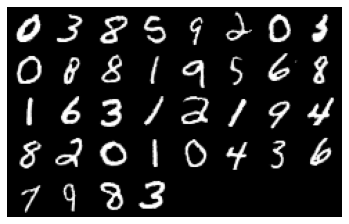

[23/100][100/938]	Loss_D: 0.4796	Loss_G: 2.7768
[23/100][200/938]	Loss_D: 0.5571	Loss_G: 1.4394
[23/100][300/938]	Loss_D: 0.6160	Loss_G: 2.1008
[23/100][400/938]	Loss_D: 0.8265	Loss_G: 2.4430
[23/100][500/938]	Loss_D: 0.5109	Loss_G: 2.0109
[23/100][600/938]	Loss_D: 0.4333	Loss_G: 2.4189
[23/100][700/938]	Loss_D: 0.8028	Loss_G: 2.0875
[23/100][800/938]	Loss_D: 0.5324	Loss_G: 2.2445
[23/100][900/938]	Loss_D: 0.8771	Loss_G: 1.9481


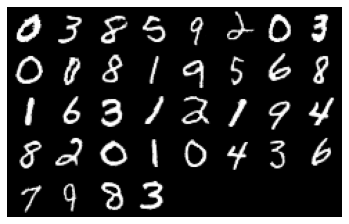

[24/100][100/938]	Loss_D: 0.5359	Loss_G: 2.3153
[24/100][200/938]	Loss_D: 0.3840	Loss_G: 2.7116
[24/100][300/938]	Loss_D: 0.6654	Loss_G: 2.1470
[24/100][400/938]	Loss_D: 0.6529	Loss_G: 2.9056
[24/100][500/938]	Loss_D: 0.6239	Loss_G: 2.0131
[24/100][600/938]	Loss_D: 0.6718	Loss_G: 2.2045
[24/100][700/938]	Loss_D: 0.4861	Loss_G: 2.3104
[24/100][800/938]	Loss_D: 0.8545	Loss_G: 1.8821
[24/100][900/938]	Loss_D: 0.5513	Loss_G: 2.3785


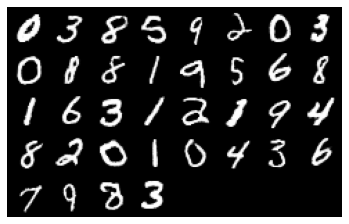

[25/100][100/938]	Loss_D: 0.4637	Loss_G: 2.9581
[25/100][200/938]	Loss_D: 0.6691	Loss_G: 1.8830
[25/100][300/938]	Loss_D: 0.4817	Loss_G: 1.8043
[25/100][400/938]	Loss_D: 0.4984	Loss_G: 2.2164
[25/100][500/938]	Loss_D: 0.5462	Loss_G: 2.6037
[25/100][600/938]	Loss_D: 0.4426	Loss_G: 2.5814
[25/100][700/938]	Loss_D: 0.4637	Loss_G: 1.5680
[25/100][800/938]	Loss_D: 0.3801	Loss_G: 2.9110
[25/100][900/938]	Loss_D: 0.4216	Loss_G: 1.7999


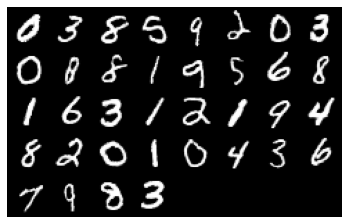

[26/100][100/938]	Loss_D: 0.6072	Loss_G: 2.3545
[26/100][200/938]	Loss_D: 0.6555	Loss_G: 1.6163
[26/100][300/938]	Loss_D: 0.3903	Loss_G: 2.4493
[26/100][400/938]	Loss_D: 0.4459	Loss_G: 2.4386
[26/100][500/938]	Loss_D: 0.4392	Loss_G: 2.3808
[26/100][600/938]	Loss_D: 0.7359	Loss_G: 2.5698
[26/100][700/938]	Loss_D: 0.5734	Loss_G: 2.2200
[26/100][800/938]	Loss_D: 0.5967	Loss_G: 2.4933
[26/100][900/938]	Loss_D: 0.4398	Loss_G: 2.5234


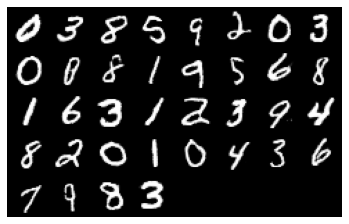

[27/100][100/938]	Loss_D: 0.5166	Loss_G: 2.4294
[27/100][200/938]	Loss_D: 0.5261	Loss_G: 3.4058
[27/100][300/938]	Loss_D: 0.6298	Loss_G: 3.5366
[27/100][400/938]	Loss_D: 0.5818	Loss_G: 2.3981
[27/100][500/938]	Loss_D: 0.4321	Loss_G: 2.9390
[27/100][600/938]	Loss_D: 0.7012	Loss_G: 2.2260
[27/100][700/938]	Loss_D: 0.7734	Loss_G: 3.1821
[27/100][800/938]	Loss_D: 0.6958	Loss_G: 1.8815
[27/100][900/938]	Loss_D: 0.7832	Loss_G: 2.9274


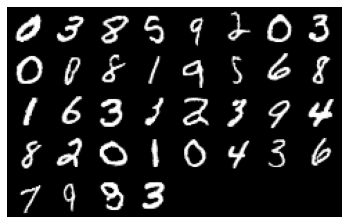

[28/100][100/938]	Loss_D: 0.3054	Loss_G: 2.8821
[28/100][200/938]	Loss_D: 0.5992	Loss_G: 1.7344
[28/100][300/938]	Loss_D: 0.5833	Loss_G: 2.6891
[28/100][400/938]	Loss_D: 0.6988	Loss_G: 1.8331
[28/100][500/938]	Loss_D: 0.5209	Loss_G: 2.1160
[28/100][600/938]	Loss_D: 0.6398	Loss_G: 2.1170
[28/100][700/938]	Loss_D: 0.6844	Loss_G: 2.4975
[28/100][800/938]	Loss_D: 0.5769	Loss_G: 3.0935
[28/100][900/938]	Loss_D: 0.6187	Loss_G: 2.0642


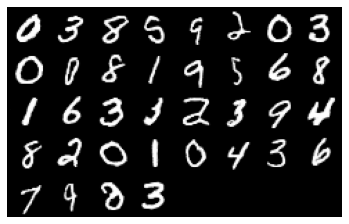

[29/100][100/938]	Loss_D: 0.7988	Loss_G: 3.6728
[29/100][200/938]	Loss_D: 0.4753	Loss_G: 2.0043
[29/100][300/938]	Loss_D: 0.4087	Loss_G: 2.6441
[29/100][400/938]	Loss_D: 1.0031	Loss_G: 3.3266
[29/100][500/938]	Loss_D: 0.4081	Loss_G: 2.9198
[29/100][600/938]	Loss_D: 0.5658	Loss_G: 2.5178
[29/100][700/938]	Loss_D: 0.4444	Loss_G: 2.6199
[29/100][800/938]	Loss_D: 0.4313	Loss_G: 2.1371
[29/100][900/938]	Loss_D: 0.5258	Loss_G: 2.2961


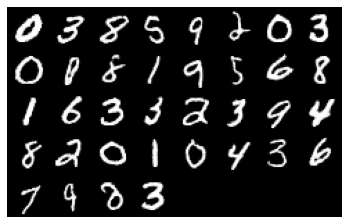

[30/100][100/938]	Loss_D: 0.4467	Loss_G: 2.4544
[30/100][200/938]	Loss_D: 0.4048	Loss_G: 2.2498
[30/100][300/938]	Loss_D: 0.4295	Loss_G: 2.4926
[30/100][400/938]	Loss_D: 0.6014	Loss_G: 3.1090
[30/100][500/938]	Loss_D: 0.3192	Loss_G: 3.1202
[30/100][600/938]	Loss_D: 0.3703	Loss_G: 2.6029
[30/100][700/938]	Loss_D: 0.6900	Loss_G: 1.1689
[30/100][800/938]	Loss_D: 0.4740	Loss_G: 3.1342
[30/100][900/938]	Loss_D: 0.5149	Loss_G: 3.2581


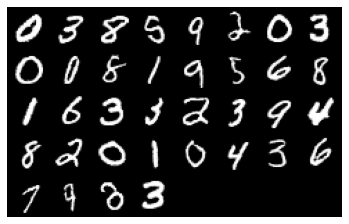

[31/100][100/938]	Loss_D: 0.4606	Loss_G: 3.0201
[31/100][200/938]	Loss_D: 0.4721	Loss_G: 2.4088
[31/100][300/938]	Loss_D: 0.5397	Loss_G: 2.1536
[31/100][400/938]	Loss_D: 0.4793	Loss_G: 2.1996
[31/100][500/938]	Loss_D: 0.5813	Loss_G: 3.0152
[31/100][600/938]	Loss_D: 0.6875	Loss_G: 2.7140
[31/100][700/938]	Loss_D: 0.4650	Loss_G: 2.4550
[31/100][800/938]	Loss_D: 0.4695	Loss_G: 2.3292
[31/100][900/938]	Loss_D: 0.6781	Loss_G: 1.9286


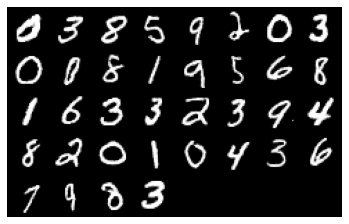

[32/100][100/938]	Loss_D: 0.5474	Loss_G: 2.0511
[32/100][200/938]	Loss_D: 0.4182	Loss_G: 3.0057
[32/100][300/938]	Loss_D: 0.7447	Loss_G: 2.8011
[32/100][400/938]	Loss_D: 0.2637	Loss_G: 2.8982
[32/100][500/938]	Loss_D: 0.3369	Loss_G: 2.9101
[32/100][600/938]	Loss_D: 0.7846	Loss_G: 2.0324
[32/100][700/938]	Loss_D: 0.3222	Loss_G: 2.7625
[32/100][800/938]	Loss_D: 0.4066	Loss_G: 2.1769
[32/100][900/938]	Loss_D: 0.7797	Loss_G: 2.8116


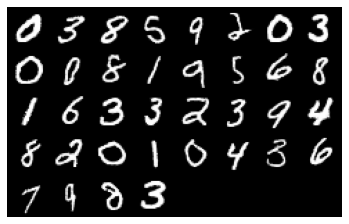

[33/100][100/938]	Loss_D: 0.5330	Loss_G: 2.4984
[33/100][200/938]	Loss_D: 0.3478	Loss_G: 3.8508
[33/100][300/938]	Loss_D: 0.2903	Loss_G: 3.0139
[33/100][400/938]	Loss_D: 0.2861	Loss_G: 2.9304
[33/100][500/938]	Loss_D: 0.6844	Loss_G: 1.7995
[33/100][600/938]	Loss_D: 0.5940	Loss_G: 2.5729
[33/100][700/938]	Loss_D: 0.4748	Loss_G: 2.5950
[33/100][800/938]	Loss_D: 0.3813	Loss_G: 2.6639
[33/100][900/938]	Loss_D: 0.6127	Loss_G: 2.4037


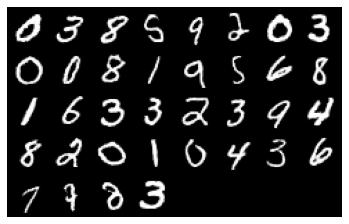

[34/100][100/938]	Loss_D: 0.2928	Loss_G: 3.7447
[34/100][200/938]	Loss_D: 0.8423	Loss_G: 2.1586
[34/100][300/938]	Loss_D: 0.7165	Loss_G: 3.2848
[34/100][400/938]	Loss_D: 0.3645	Loss_G: 3.1280
[34/100][500/938]	Loss_D: 0.4332	Loss_G: 3.7045
[34/100][600/938]	Loss_D: 0.5126	Loss_G: 3.1609
[34/100][700/938]	Loss_D: 0.6422	Loss_G: 2.3071
[34/100][800/938]	Loss_D: 0.5697	Loss_G: 1.9768
[34/100][900/938]	Loss_D: 1.0052	Loss_G: 1.3446


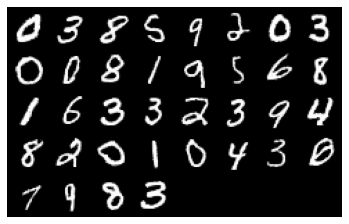

[35/100][100/938]	Loss_D: 0.5245	Loss_G: 2.4757
[35/100][200/938]	Loss_D: 0.4319	Loss_G: 2.7278
[35/100][300/938]	Loss_D: 0.4399	Loss_G: 2.7673
[35/100][400/938]	Loss_D: 0.4652	Loss_G: 2.5551
[35/100][500/938]	Loss_D: 0.4340	Loss_G: 2.4716
[35/100][600/938]	Loss_D: 0.4906	Loss_G: 2.5073
[35/100][700/938]	Loss_D: 0.4700	Loss_G: 2.6206
[35/100][800/938]	Loss_D: 0.3678	Loss_G: 3.0043
[35/100][900/938]	Loss_D: 0.7289	Loss_G: 3.2518


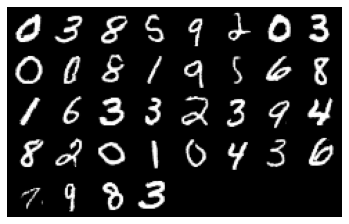

[36/100][100/938]	Loss_D: 0.5467	Loss_G: 2.9767
[36/100][200/938]	Loss_D: 0.3541	Loss_G: 2.4762
[36/100][300/938]	Loss_D: 0.3920	Loss_G: 3.3349


In [ ]:
infoGAN = InfoGAN(params)
infoGAN.train(dataloader, 100)

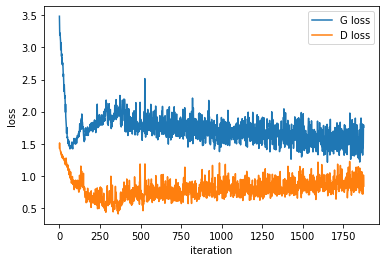

In [ ]:
plt.plot(infoGAN.G_losses)
plt.plot(infoGAN.D_losses)
plt.legend(['G loss', 'D loss'])
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()

SyntaxError: ignored